In [1]:
# Load the necessary libraries
import numpy as np
import sympy as sp
from sympy.physics.mechanics import dynamicsymbols
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# This is for pretty printing
import IPython.display as disp

In [2]:
m1, m2, m3, m4, m5, m_fw = 2, 3, 0.5, 3, 0.5, 10
L1, L2, L4, R_fw = 1, 1.5, 1.5, 0
I1, I2, I4 = m1*L1**2/12 + m_fw*R_fw**2/2, m2*L2**2/12, m4*L4**2/12
F0 = 50
k = 1
g = 9.81

In [3]:
t = sp.symbols('t')
x1, x2, x3, x4, x5, = dynamicsymbols('x1 x2 x3 x4 x5')
y1, y2, y3, y4, y5 = dynamicsymbols('y1 y2 y3 y4 y5')
theta1, theta2, theta4 = dynamicsymbols('theta1 theta2 theta4')
q = sp.Matrix([x1, y1, theta1, x2, y2, theta2, x3, y3, x4, y4, theta4, x5, y5])

x_com_1 = sp.Matrix([x1, y1])
x_com_2 = sp.Matrix([x2, y2])
x_com_3 = sp.Matrix([x3, y3])
x_com_4 = sp.Matrix([x4, y4])
x_com_5 = sp.Matrix([x5, y5])

R = lambda theta: sp.Matrix([[sp.cos(theta), -sp.sin(theta)], [sp.sin(theta), sp.cos(theta)]])

In [4]:
M = np.diag([m1, m1, I1, m2, m2, I2, m3, m3, m4, m4, I4, m5, m5])
W = np.linalg.inv(M)

In [5]:
Q = sp.Matrix([0, -m1*g, -k*theta1.diff(t), 0, -m2*g, 0, 0, -m3*g+F0*sp.cos(theta1), 0, -m4*g, 0, 0, -m5*g-F0*sp.cos(theta1)])

In [6]:
i_cap = sp.Matrix([1, 0])
j_cap = sp.Matrix([0, 1])

# Pin constraint at A
con_A = x_com_1
C1 = con_A.dot(i_cap)
C2 = con_A.dot(j_cap)

# Hinge constraint at B
con_B = x_com_1 + R(theta1) @ sp.Matrix([L1/2, 0]) - x_com_2 - R(theta2) @ sp.Matrix([-L2/2, 0])
C3 = con_B.dot(i_cap)
C4 = con_B.dot(j_cap)

# Prismatic constraint at C
C5 = x_com_3[0]
con_C = x_com_3 - x_com_2 - R(theta2) @ sp.Matrix([L2/2, 0])
C6 = con_C.dot(i_cap)
C7 = con_C.dot(j_cap)

# Hinge constraint at D
con_D = x_com_1 + R(theta1) @ sp.Matrix([-L1/2, 0]) - x_com_4 - R(theta4) @ sp.Matrix([L4/2, 0])
C8 = con_D.dot(i_cap)
C9 = con_D.dot(j_cap)

# Prismatic constraint at E
C10 = x_com_5[0]
con_E = x_com_5 - x_com_4 - R(theta4) @ sp.Matrix([-L4/2, 0])
C11 = con_E.dot(i_cap)
C12 = con_E.dot(j_cap)

C = sp.Matrix([C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, C11, C12])
C

Matrix([
[                                                   x1(t)],
[                                                   y1(t)],
[x1(t) - x2(t) + 0.5*cos(theta1(t)) + 0.75*cos(theta2(t))],
[y1(t) - y2(t) + 0.5*sin(theta1(t)) + 0.75*sin(theta2(t))],
[                                                   x3(t)],
[                    -x2(t) + x3(t) - 0.75*cos(theta2(t))],
[                    -y2(t) + y3(t) - 0.75*sin(theta2(t))],
[x1(t) - x4(t) - 0.5*cos(theta1(t)) - 0.75*cos(theta4(t))],
[y1(t) - y4(t) - 0.5*sin(theta1(t)) - 0.75*sin(theta4(t))],
[                                                   x5(t)],
[                    -x4(t) + x5(t) + 0.75*cos(theta4(t))],
[                    -y4(t) + y5(t) + 0.75*sin(theta4(t))]])

In [7]:
J = C.jacobian(q)
dq = q.diff(t)
dC = J @ dq
dJ = dC.jacobian(q)
JWJT = J @ W @ J.T
RHS = -dJ @ dq - J @ W @ Q - 1 * C - 1 * dC

JWJT_fn = sp.lambdify(args=(q, dq), expr=JWJT)
RHS_fn = sp.lambdify(args=(q, dq), expr=RHS)
C_fn = sp.lambdify(args=(q, dq), expr=C)
J_fn = sp.lambdify(args=(q, dq), expr=J)
dC_fn = sp.lambdify(args=(q, dq), expr=dC)
dJ_fn = sp.lambdify(args=(q, dq), expr=dJ)
Q_fn = sp.lambdify(args=(q, dq), expr=Q)

In [8]:
import scipy.optimize as opt

initial_position_body_1 = np.array([0, 0, 0])
initial_position_body_2 = np.array([L1/4, np.sqrt(L2**2-L1**2/4)/2, np.pi-np.arccos(L1/(2*L2))])
initial_position_body_3 = np.array([0, np.sqrt(L2**2-L1**2/4)])
initial_position_body_4 = np.array([-L1/4, -np.sqrt(L4**2-L1**2/4)/2, np.pi-np.arccos(L1/(2*L4))])
initial_position_body_5 = np.array([0, -np.sqrt(L4**2-L1**2/4)])

initial_velocity_body_1 = np.array([0, 0, 0])
initial_velocity_body_2 = np.array([0, 0, 0])
initial_velocity_body_3 = np.array([0, 0])
initial_velocity_body_4 = np.array([0, 0, 0])
initial_velocity_body_5 = np.array([0, 0])

x0 = np.concatenate((initial_position_body_1, initial_position_body_2, initial_position_body_3, initial_position_body_4, initial_position_body_5,
                    initial_velocity_body_1, initial_velocity_body_2, initial_velocity_body_3, initial_velocity_body_4, initial_velocity_body_5))

In [9]:
x, dx = np.split(x0, 2)
C_val = C_fn(x, dx)
dC_val = dC_fn(x, dx)

pos_res_norm = np.linalg.norm(C_val)
vel_res_norm = np.linalg.norm(dC_val)
print(pos_res_norm, vel_res_norm)


print(f'Position constraint: {C_val}')
print(f'Velocity constraint: {dC_val}')
assert np.allclose(C_val, 0), "Initial position constraint violated"
assert np.allclose(dC_val, 0), "Initial velocity constraint violated"

2.5133742693021536e-16 0.0
Position constraint: [[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.11022302e-16]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.38777878e-16]
 [ 0.00000000e+00]
 [-1.11022302e-16]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.38777878e-16]
 [ 0.00000000e+00]]
Velocity constraint: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [10]:
def piston_engine(t, state):
    '''
    This function returns the derivative of the state vector for the system

    Parameters:
    t: float
        The current time
    state: numpy array
        The current state of the system
        The vector is arranged as [q, dq]
        where q is the position vector and dq is the derivative of the position vector
    '''

    q, dq = np.split(state, 2)

    # Solve for lambda
    lam = np.linalg.solve(JWJT_fn(q,dq), RHS_fn(q,dq))

    # Solve for constraint forces
    Qhat = J_fn(q, dq).T @ lam

    # Calculate accelerations
    ddq = W @ (Q_fn(q, dq) + Qhat)
    ddq = ddq.flatten()

    return np.concatenate((dq, ddq))

# Test run
piston_engine(0, x0)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.77635684e-15,  2.60869565e+01,
       -2.73855013e-15,  1.30434783e+01,  3.15796771e-15,  0.00000000e+00,
        1.30434783e+01,  2.72374715e-14, -1.30434783e+01,  4.06588343e-14,
        0.00000000e+00, -1.30434783e+01])

In [11]:
t_span = (0, 15)
t_eval = np.linspace(*t_span, 500)
sol = solve_ivp(piston_engine, t_span, x0, atol=1e-7, rtol=1e-7, method='BDF', t_eval=t_eval)

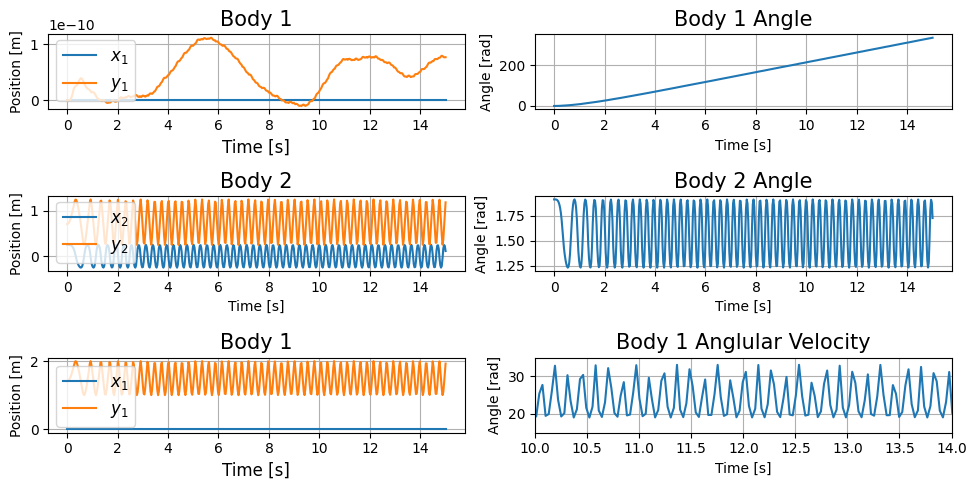

In [12]:
# Plot the result
fig, ax = plt.subplots(3, 2, figsize=(10, 5))
ax[0, 0].plot(sol.t, sol.y[0], label=r'$x_1$')
ax[0, 0].plot(sol.t, sol.y[1], label=r'$y_1$')
ax[0, 0].set_xlabel("Time [s]", fontsize=12)
ax[0, 0].set_ylabel("Position [m]")
ax[0, 0].legend(fontsize=12)
ax[0, 0].set_title("Body 1", fontsize=15)

ax[0, 1].plot(sol.t, sol.y[2], label=r'$\theta_1$')
ax[0, 1].set_title(r"Body 1 Angle", fontsize=15)
ax[0, 1].set_xlabel("Time [s]")
ax[0, 1].set_ylabel("Angle [rad]")

ax[1, 0].plot(sol.t, sol.y[3], label=r'$x_2$')
ax[1, 0].plot(sol.t, sol.y[4], label=r'$y_2$')
ax[1, 0].set_xlabel("Time [s]")
ax[1, 0].set_ylabel("Position [m]")
ax[1, 0].legend(fontsize=12)
ax[1, 0].set_title("Body 2", fontsize=15)

ax[1, 1].plot(sol.t, sol.y[5], label=r'$\theta_2$')
ax[1, 1].set_title(r'Body 2 Angle', fontsize=15)
ax[1, 1].set_xlabel("Time [s]")
ax[1, 1].set_ylabel("Angle [rad]")

ax[2, 0].plot(sol.t, sol.y[6], label=r'$x_1$')
ax[2, 0].plot(sol.t, sol.y[7], label=r'$y_1$')
ax[2, 0].set_xlabel("Time [s]", fontsize=12)
ax[2, 0].set_ylabel("Position [m]")
ax[2, 0].legend(fontsize=12)
ax[2, 0].set_title("Body 1", fontsize=15)

ax[2, 1].plot(sol.t, sol.y[15], label=r'$\theta_1$')
ax[2, 1].set_title(r"Body 1 Anglular Velocity", fontsize=15)
ax[2, 1].set_xlabel("Time [s]")
ax[2, 1].set_ylabel("Angle [rad]")
ax[2, 1].set_xlim(10, 14)
ax[2, 1].set_ylim(15, 35)


# Add some grid lines
for a in ax.flatten():
    a.grid(which='both')
    #a.set_xlim(t_span)

fig.tight_layout()


In [13]:
class Box:
    def __init__(self, width, height, color='b'):
        self.width  = width
        self.height = height
        self.color  = color
        # rectangle is drawn from its bottom-left corner, so we offset
        self.offset = -np.array([width/2, height/2])

    def first_draw(self, ax):
        # place it initially at (0,0), zero angle
        corner = np.array([0.0, 0.0])
        # create the patch with the correct size
        self.patch = plt.Rectangle(
            corner,
            self.width,
            self.height,
            angle=0,
            rotation_point='center',
            color=self.color,
            animated=True
        )
        ax.add_patch(self.patch)
        self.ax = ax
        return self.patch

    def set_data(self, x_traj, y_traj, theta_traj):
        # store the 1D arrays for update later
        self.x     = x_traj
        self.y     = y_traj
        self.theta = theta_traj

    def update(self, i):
        # fetch frame-i
        x, y, theta = self.x[i], self.y[i], self.theta[i]
        theta_deg   = np.rad2deg(theta)

        # compute bottom-left corner from center-offset
        corner = np.array([x, y]) + self.offset

        # update the patch
        self.patch.set_width(self.width)
        self.patch.set_height(self.height)
        self.patch.set_xy(corner)
        self.patch.set_angle(theta_deg)
        return self.patch

RuntimeError: Requested MovieWriter (ffmpeg) not available

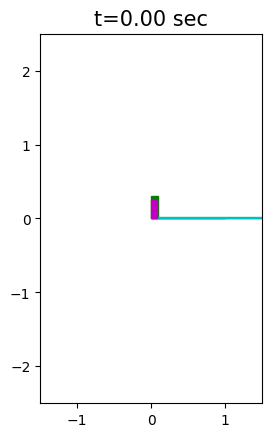

In [14]:
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Example indexing for 5 bodies:
#   body1 — 3 DOF, body2 — 3 DOF, body3 — 2 DOF, body4 — 3 DOF, body5 — 2 DOF
# Adjust slices to match your actual state-vector ordering!

# body 1 (x₁, y₁, θ₁)
x1, y1, theta1 = sol.y[  0:  3]
# body 2 (x₂, y₂, θ₂)
x2, y2, theta2 = sol.y[  3:  6]
# body 3 (x₃, y₃) — no rotation
x3, y3        = sol.y[  6:  8]
theta3        = np.zeros_like(x3)
# body 4 (x₄, y₄, θ₄)
x4, y4, theta4= sol.y[  8: 11]
# body 5 (x₅, y₅) — no rotation
x5, y5        = sol.y[ 11: 13]
theta5        = np.zeros_like(x5)

# --------------------------------------
# 3) Create one Box per body
# --------------------------------------
box1 = Box(width=L1,  height=0.01, color='b')
box2 = Box(width=L2,  height=0.01, color='r')
box3 = Box(width=0.1, height=0.30, color='g')
box4 = Box(width=L4,  height=0.02, color='c')
box5 = Box(width=0.08, height=0.25, color='m')

# give each its trajectory
box1.set_data(x1, y1, theta1)
box2.set_data(x2, y2, theta2)
box3.set_data(x3, y3, theta3)
box4.set_data(x4, y4, theta4)
box5.set_data(x5, y5, theta5)

# pack into a list of length 5
boxes = [box1, box2, box3, box4, box5]

# --------------------------------------
# 4) Animation init & frame functions
# --------------------------------------
x_min, x_max = -1.5, 1.5
y_min, y_max = -2.5, 2.5

fig, ax = plt.subplots()
ax.set_aspect('equal', 'box')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

def init():
    ax.set_title("t=0.00 sec", fontsize=15)
    # draw each box once
    for box in boxes:
        box.first_draw(ax)
    # return all patches
    return [b.patch for b in boxes]

def animate(i):
    ax.set_title(f"t={sol.t[i]:.2f} sec", fontsize=15)
    # update each box
    for box in boxes:
        box.update(i)
    return [b.patch for b in boxes]

dt   = sol.t[1] - sol.t[0]
anim = FuncAnimation(
    fig,
    animate,
    frames=len(sol.t),
    init_func=init,
    blit=False,
    interval=1000*dt
)

# Display in notebook
HTML(anim.to_html5_video())